In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import plotly.express as px

In [2]:
# Reading only ORF similarities since YAP1 does not have a phenotype in CRISPR

orf_similarity_df = pd.read_parquet('cos_sim/cosine_similarities_genes_orf.parquet')

In [3]:
# All YAP1 connections in KG with score > 0.7

knowledge_graph = pd.read_csv(
    "~/Downloads/orf_scores_merged.zip",
    sep="\t",
    usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
).rename(
    columns={
        "GENE1": "gene_1",
        "GENE2": "gene_2",
        "gene_mf__go": "gene_mf",
        "gene_bp__go": "gene_bp",
    }
)

knowledge_graph = pd.concat(
    [
        knowledge_graph,
        knowledge_graph.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
)

knowledge_graph_unknown = (
    knowledge_graph.assign(
        gene_kg=lambda x: np.max(
            x[["gene_mf", "gene_bp", "gene_pathway"]].abs(), axis=1
        )
    )
    .query("gene_kg > 0.7")
    .query("gene_1=='YAP1'")[["gene_1", "gene_2", "gene_kg"]]
)

In [4]:
# YAP1 strongest n connections

n = 10

yap1_df = (
    orf_similarity_df["YAP1"]
    .reset_index()
    .rename(columns={"index": "Metadata_Gene_Symbol", "YAP1": "similarity"})
    .query(
        "Metadata_Gene_Symbol!='YAP1' and Metadata_Gene_Symbol !='PHACTR1' and Metadata_Gene_Symbol !='SYT2'"
    )
    .query("Metadata_Gene_Symbol in @knowledge_graph_unknown.gene_2")
)

yap1_df["similarity"] = np.abs(yap1_df["similarity"])

yap1_gene_list = (
    list(yap1_df.nlargest(n, "similarity").Metadata_Gene_Symbol)
    # + list(yap1_df.nsmallest(n, "similarity").Metadata_Gene_Symbol)
    + ["YAP1"]
)

In [5]:
# Create ORF table and knowledge graph table for plotting

orf_values = np.abs(orf_similarity_df.loc[yap1_gene_list, yap1_gene_list].values)
np.fill_diagonal(orf_values, 1)
orf_df = pd.DataFrame(orf_values, index=yap1_gene_list, columns=yap1_gene_list)

knowledge_graph = knowledge_graph.query("gene_1 in @yap1_gene_list").query(
    "gene_2 in @yap1_gene_list"
)

knowledge_graph = pd.pivot(
    knowledge_graph.assign(
        gene_kg=lambda x: np.max(
            x[["gene_mf", "gene_bp", "gene_pathway"]].abs(), axis=1
        )
    ),
    index="gene_1",
    columns="gene_2",
    values="gene_kg",
).fillna(1)

In [6]:
# Map gene names to NCBI gene ID

ncbi_map = pd.read_csv(
    "../00.download-and-process-annotations/output/ncbi_dataset_processed.tsv", sep="\t"
)

ncbi_map = ncbi_map.query("Approved_Symbol in @yap1_gene_list")

coexpression_df = pd.DataFrame()

for gene_id in ncbi_map.NCBI_Gene_ID:
    gene_name = ncbi_map.query("NCBI_Gene_ID == @gene_id").Approved_Symbol.values[0]
    try:
        df = pd.read_csv(
            f"../../coexpression/{gene_id}",
            header=None,
            sep="\t",
            names=["NCBI_Gene_ID", "coexpression"],
        )
        df = (
            df.merge(ncbi_map, on="NCBI_Gene_ID", how="inner")
            .drop(columns="NCBI_Gene_ID")
            .assign(gene_1=gene_name)
            .rename(columns={"Approved_Symbol": "gene_2"})
        )
        coexpression_df = pd.concat([coexpression_df, df], ignore_index=True)
    except FileNotFoundError:
        continue

coexpression_df = pd.pivot(
    coexpression_df, index="gene_1", columns="gene_2", values="coexpression"
)

coexpression_values = np.abs(coexpression_df.values)
np.fill_diagonal(coexpression_values, 1)
coexpression_df = pd.DataFrame(
    coexpression_values,
    index=coexpression_df.columns.to_list(),
    columns=coexpression_df.columns.to_list(),
)

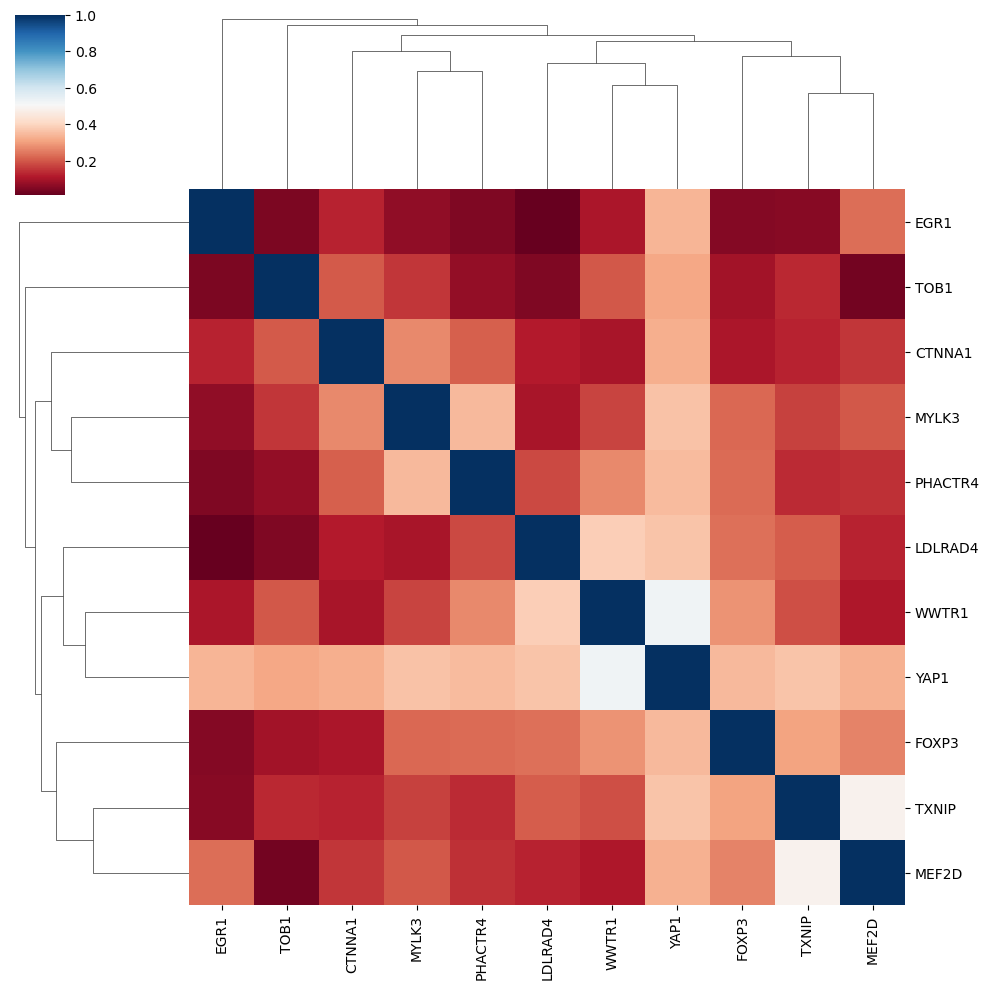

In [7]:
g = sns.clustermap(
    orf_df,
    cmap="RdBu",
    vmin=np.min(orf_df.values),
    vmax=np.max(orf_df.values),
)

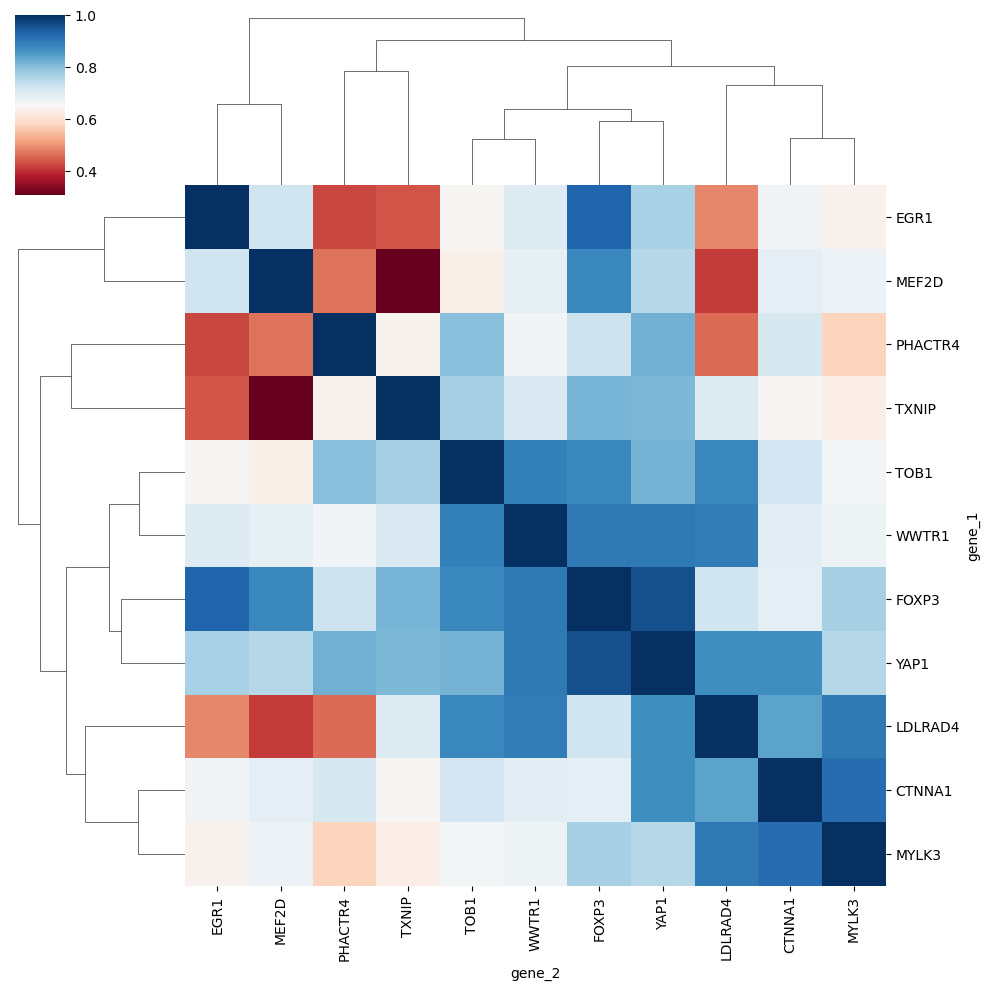

In [8]:
g = sns.clustermap(
    knowledge_graph,
    cmap="RdBu",
    vmin=np.min(knowledge_graph.values),
    vmax=np.max(knowledge_graph.values),
)
plt.show()

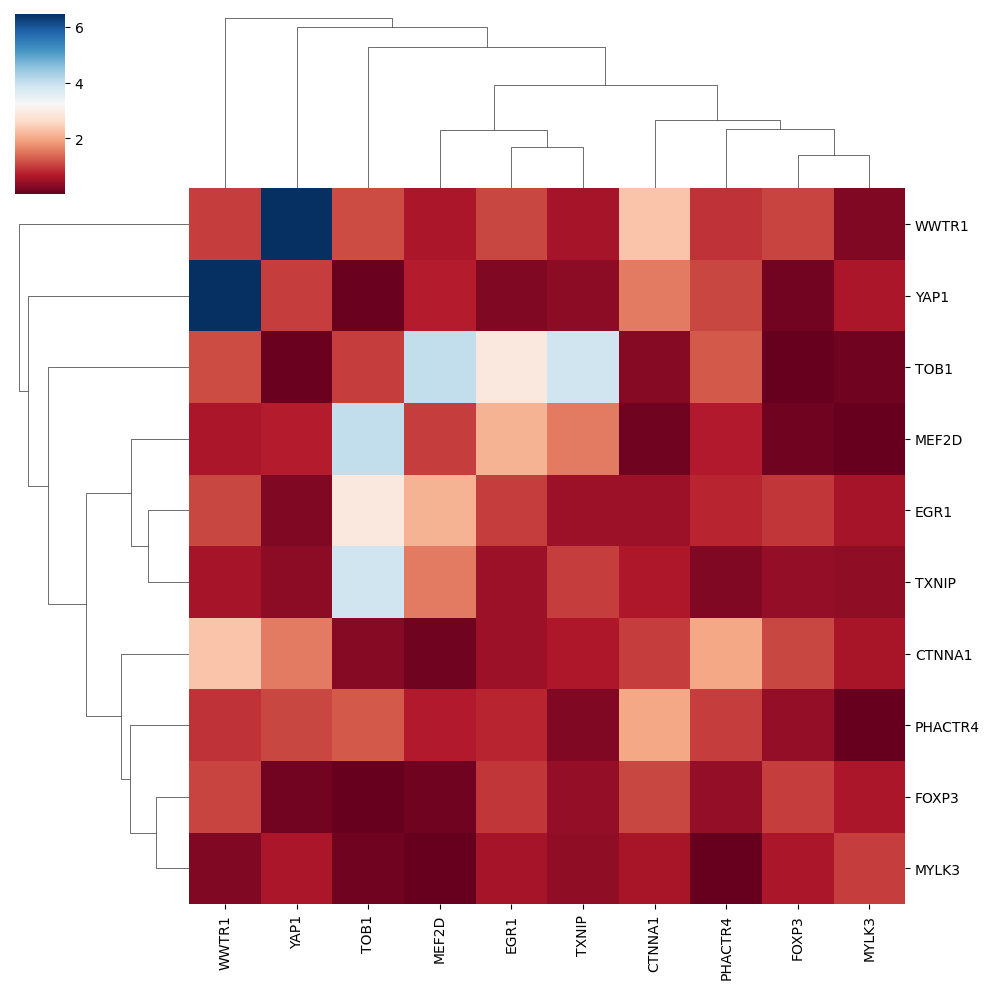

In [9]:
g = sns.clustermap(
    coexpression_df,
    cmap="RdBu",
    vmin=np.min(coexpression_df.values),
    vmax=np.max(coexpression_df.values),
)
plt.show()

In [10]:
df1 = (
    orf_df["YAP1"]
    .reset_index()
    .rename(columns={"index": "Metadata_Gene_Symbol", "YAP1": "Similarity"})
)

df2 = (
    knowledge_graph["YAP1"]
    .reset_index()
    .rename(
        columns={
            "gene_1": "Metadata_Gene_Symbol",
            "YAP1": "Knowledge_graph",
        }
    )
)

df3 = (
    coexpression_df["YAP1"]
    .reset_index()
    .rename(
        columns={
            "index": "Metadata_Gene_Symbol",
            "YAP1": "Coexpression",
        }
    )
)

df = (
    df1.merge(df2, on="Metadata_Gene_Symbol")
    .merge(df3, on="Metadata_Gene_Symbol")
    .query("Metadata_Gene_Symbol != 'YAP1'")
)

Rsquared:0.13550322782197066


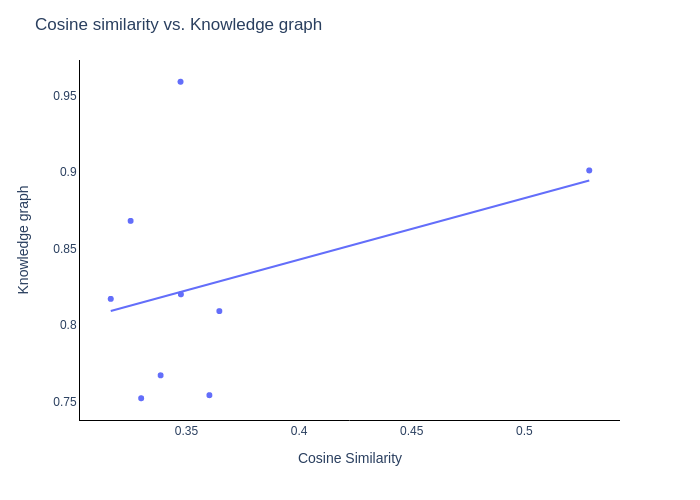

In [11]:
fig = px.scatter(
    df, x="Similarity", y="Knowledge_graph", trendline="ols"
).update_layout(
    title=f"Cosine similarity vs. Knowledge graph",
    xaxis=dict(title="Cosine Similarity", linecolor="black"),
    yaxis=dict(title="Knowledge graph", linecolor="black"),
    plot_bgcolor="white",
)
print(f"Rsquared:{px.get_trendline_results(fig).iloc[0]['px_fit_results'].rsquared}")
fig.show("png")

Rsquared:0.8714451057242617


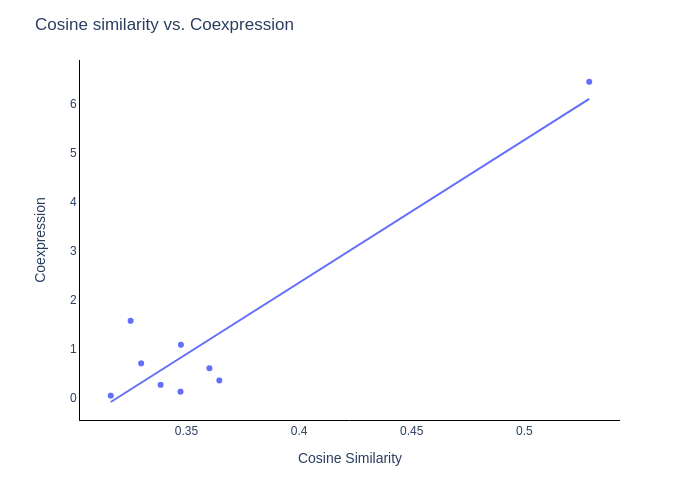

In [12]:
fig = px.scatter(
    df, x="Similarity", y="Coexpression", trendline="ols"
).update_layout(
    title=f"Cosine similarity vs. Coexpression",
    xaxis=dict(title="Cosine Similarity", linecolor="black"),
    yaxis=dict(title="Coexpression", linecolor="black"),
    plot_bgcolor="white",
)
print(f"Rsquared:{px.get_trendline_results(fig).iloc[0]['px_fit_results'].rsquared}")
fig.show("png")

Rsquared:0.14159301681894165


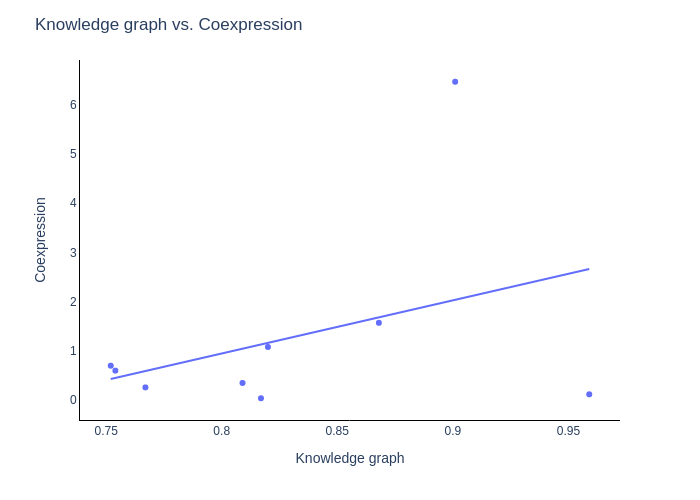

In [13]:
fig = px.scatter(
    df, x="Knowledge_graph", y="Coexpression", trendline="ols"
).update_layout(
    title=f"Knowledge graph vs. Coexpression",
    xaxis=dict(title="Knowledge graph", linecolor="black"),
    yaxis=dict(title="Coexpression", linecolor="black"),
    plot_bgcolor="white",
)

print(f"Rsquared:{px.get_trendline_results(fig).iloc[0]['px_fit_results'].rsquared}")
fig.show("png")